In [ ]:
import numpy as np
import plotly.subplots
import pandas as pd
import typing
import jax
import jax.numpy as jnp
import numpy as np
import plotly.graph_objects as go
from jax.nn import softmax

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In this homework I downloaded the MNIST database already aveilable in colab on the sample_data folder. The database collects images of handwritten digits *0,1,2,…,9* by a group of American Census Bureau employees and a group of American high school students. The handwritten digits have been stored as 28x28 pixel grayscale images, with grayscale levels ranging from 0 to 255.
The database has been divided in training (***mnist_train_small.csv***) and testing (***mnist_test.csv***) datasets.
Each row of the csv file represents an entry of the dataset. The first column stores the value of the digit represented in the image, while each of the remaining 28x28=784 columns stores the grayscale level of a single pixel of the image.
The goal of this homework is to set up a digit recognition, which using a feedforward neural network able to predict the value of the digit of the handwritten image based on the pixels of the image.

In [ ]:
train_data = pd.read_csv("sample_data/mnist_train_small.csv",header=None)

With the rows below, I selected the column which corresponds to the label (y_train) and the columns that correspond to the features (x_train).

In [ ]:
y_train=train_data.iloc[:,0].to_numpy()
x_train=train_data.iloc[:,1:].to_numpy()
print(y_train.shape)
print(x_train.shape)

(20000,)
(20000, 784)


Here, ***Y_train*** is a matrix with as many rows as the training dataset and 10 columns, gotten by applying the one-hot encoding to the first column of the ***train_data*** that I previously called ***y_train***.
On the other hand, ***X_train*** is a matrix with as many rows as the training dataset (***train_data***) and 784 columns, which are obtained by normalizing between 0 and 1 the columns of the features (***x_train***)

In [ ]:
# Apply one-hot encoding to labels
encoder = OneHotEncoder(sparse=False, categories='auto')
Y_train = encoder.fit_transform(y_train.reshape(-1,1))
# Normalize features between 0 and 1
scaler = MinMaxScaler() #standard is 0 and 1, if we would like to normalize #
#for instance between 3 and 6 we have to specify MinMaxScaler(feature_range=(3,6))
X_train = scaler.fit_transform(x_train)
print(Y_train.shape)
X_train.shape[1]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(20000, 10)


784

In [ ]:
df_x_train=pd.DataFrame(X_train)
df_x_train.head(10)

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, in order to visualize the data, I used the following function to visualize the first 50 images in the training dataset and their corresponding labels. The function visualize_digits_and_labels accepts two input arguments X and Y, corresponding respectively to the matrix of features and the matrix of one-hot encoded labels that I defined above.

In [ ]:
def visualize_digits_and_labels(X: np.ndarray, Y: np.ndarray) -> None:
    """Visualize digits as images and labels as titles."""
    # Check input arguments
    assert X.shape[0] == Y.shape[0]
    m = X.shape[0]
    assert X.shape[1] == 28 * 28
    assert Y.shape[1] == 10

    # Reverse one-hot encoding to determine the digit number
    digits = np.argwhere(Y == 1)[:, 1]

    # Create a new figure with 10 images per row, and assign titles to each subplot
    ncols = 10
    nrows = int(np.ceil(X.shape[0] / ncols))
    assert nrows < 6, "Do not try to plot more than 50 images"
    fig = plotly.subplots.make_subplots(rows=nrows, cols=ncols, subplot_titles=[str(d) for d in digits])

    # Loop over images and add to subplot
    j = 0
    for row in range(nrows):
        for col in range(ncols):
            if j >= m:
                break

            img_j = X[j].reshape((28, 28))
            fig.add_heatmap(z=img_j, colorscale="gray_r", showscale=False, row=row + 1, col=col + 1)
            j += 1

    fig.update_yaxes(autorange="reversed", constrain="domain", scaleanchor="x", showticklabels=False)
    fig.update_xaxes(constrain="domain", showticklabels=False)
    fig.show()

In [ ]:
visualize_digits_and_labels(x_train[0:50,:],Y_train[0:50,:])

In the above figure we can see the first 50 images in the training dataset and their corresponding labels

Now it's time to implement the network. First of all we decided to initialize the weights and biases using the following criterua:

* Initialize biases to zero;
* Initialize weights al layer l sampling from a Gaussian Distribution with zero mean and standard deviation equal to:
$\sqrt \frac{2}{d_{l-1}-d_l}$.

This method is called Xavier normalization. The goal of Xavier normalization is to handle the problem of correct initialization of weights in a neural network so as to promote faster convergence during training. When weights are initialized too large or too small, they could cause problems such as gradient burst or disappearance during back propagation, hindering network learning. Xavier normalization proposes a specific formula for initializing weights, which takes into account the number of input and output units in a particular layer of the network. In general, this technique attempts to keep the variance of the weights constant across the layers of the network, thus helping to mitigate the problems associated with gradient propagation.


In the code below, d is a vector that contains the number of neurons per layer where the input layer contains 784 neurons (number of features in the training dataset) and the output layer contains 10 neurons since in our training data our output is a digit between 0 and 9. While 50 and 30 are the number of neurons in the two hidden layers.


In [ ]:
np.random.seed(31 + 300)
d = [784, 50, 30, 10]
W_1 = np.random.normal(0, np.sqrt(2 / (d[0] + d[1])), size=(d[1], d[0]))
print("W_1 shape:", W_1.shape)
b_1 = np.zeros((d[1], 1))
print("b_1 shape:", b_1.shape)
W_2 = np.random.normal(0, np.sqrt(2 / (d[1] + d[2])), size=(d[2], d[1]))
print("W_2 shape:", W_2.shape)
b_2 = np.zeros((d[2], 1))
print("b_2 shape:", b_2.shape)
W_3 = np.random.normal(0, np.sqrt(2 / (d[2] + d[3])), size=(d[3], d[2]))
print("W_3 shape:", W_3.shape)
b_3 = np.zeros((d[3], 1))
print("b_3 shape:", b_3.shape)

W_1 shape: (50, 784)
b_1 shape: (50, 1)
W_2 shape: (30, 50)
b_2 shape: (30, 1)
W_3 shape: (10, 30)
b_3 shape: (10, 1)


Our network can be defined as follows:

* a matrix $W_1 \in R^{50x784}$  which collects the weights connecting nodes in the input layer to the first hidden layer
* a vector $b_1 \in R^{50}$ which collects the biases associated to each node in the first hidden layer;

* a matrix $W_2 \in R^{30X50}$ which collects the weights connecting nodes in the first hidden layer to the second hidden layer;
* a vector $b_2 \in R^{30}$ which collects the biases associated to each node in the second hidden layer

* a matrix $W_3 \in R^{10X30}$ which collects the weights connecting nodes in the second hidden layer to the output layer;
* a vector $b_3 \in R^{10}$ which collects the biases associated to each node in the output layer

In [ ]:
W_0=[W_1,b_1,W_2,b_2,W_3,b_3]

Now I wrote a Python function that implements a feedforward neural network. The function takes as inputs the vector $x$ of features, and a list $w$ collecting all weights and biases.
I used ***tanh*** as activation function on the two hidden layers composed by 50 and 30 neurons respectively. This activation function is a mathematical function that maps a real number in the range between -1 and 1. The mathematical formula for the hyperbolic tangent function is as follows:
$tanh(x)=\frac{e^{2x}-1}{e^{2x}+1}$ where x is the input.
It is often used as an activation function in neural units because it produces outputs centered around 0, which can help mitigate problems such as the gradient disappearance problem.
On the other hand, on the output layer, I applied the ***softmax function*** defined as follows:

$\sigma = \frac{1}{\sum_{h=0}^{9}exp(z_h)} \begin{bmatrix} exp(z_0) \\ exp(z_1) \\ \vdots \\ exp(z_9) \end{bmatrix}$.

As we know from the theory, the softmax function is chosen to allow interpretation of the outputs as probabilities. Thus (the output layer counting neurons starting from 0), if neuron 0 of the output layer has the largest value of all other neurons of the output layer, then the image will be classified as containing the digit 0; similarly, if neuron 1 has the largest value of all, the image will be classified as containing the digit 1, and so on.



In [ ]:
def feedforward_neural_network_classification(x: np.ndarray, w: typing.List[np.ndarray]) -> np.ndarray:
    (W_1, b_1, W_2, b_2, W_3, b_3) = w

    # Handle x of different shapes (come back to this after point 3)
    if len(x.shape) == 2:
        x = x.T
    else:
        x = x.reshape(-1, 1)

    # Layer 0 is composed by the input features x
    layer_0 = x

    # Use layer 0, the weights W_1 and the biases b_1 to activate layer 1
    layer_1 = jnp.tanh(jnp.dot(W_1, layer_0) + b_1)

    # Use layer 1, the weights W_2 and the biases b_2 to activate layer 2
    layer_2 = jnp.tanh(jnp.dot(W_2, layer_1) + b_2)

    # Use layer 2, the weights W_3 and the biases b_3 to compute (without activation) the output layer
    layer_3 = jnp.dot(W_3, layer_2) + b_3

    #output=softmax(layer_3,axis=0)
    output = jnp.exp(layer_3 - jnp.max(layer_3)) / jnp.sum(jnp.exp(layer_3 - jnp.max(layer_3)), axis=0)


    # Apply the transformation back before returning
    if len(x.shape) == 2:
        return output.T
    else:
        return output.reshape(-1, 1)

To see whether my network is working properly, I test my implementation on the following input: w as initialized at step defined above and $x$ equal to the first two training entries. As we expected, in those two cases the neural network returns 2 vectors with 10 outputs (2x10  matrix). In any case, the sum of the outputs associated to each entry is expected to be one.

In [ ]:
x_first_two_entries = x_train[:2]
output_first_two_entries = feedforward_neural_network_classification(x_first_two_entries, W_0)
print("Output with x = the first two training entries:\n", output_first_two_entries)
np.sum(output_first_two_entries,axis=1)

Output with x = the first two training entries:
 [[0.01071759 0.12708594 0.16756657 0.1311338  0.16523933 0.20668367
  0.02950422 0.04315941 0.07033239 0.04857701]
 [0.03464121 0.04773478 0.07532255 0.19343433 0.06775685 0.22447146
  0.12421516 0.05220611 0.0736111  0.10660645]]


Array([0.99999994, 1.        ], dtype=float32)

In this part I implemented the ***cross-entropy loss***. To do so, I wrote a Python function that implements the mini-batch empirical risk associated to the ***cross-entropy loss***. The function should take as inputs a matrix X of features, a matrix Y of the one-hot encoded labels and a list of the weights and biases to be used in the evaluation of the neural network.
We have to keep in mind that the cross-entropy loss in computed as follows:

$l(y,\widehat y)=-\sum_\limits{h=0}^9y^{h} log(\widehat y^{h})$ where: $y \in R^{10}$ is the one-hot encoded label associated to an entry with features $x \in R^{784}$ and $\widehat y \in R^{10}$ is the output of the neural network on the same entry $x$.


In [ ]:
def mini_batch_empirical_risk_slow(X, Y, w):
    m = X.shape[0]
    return 1/m * -np.sum([Y[j] * np.log(feedforward_neural_network_classification(X[j], w))
                         for j in range(m)])

In [ ]:
def mini_batch_empirical_risk_classification(X: np.ndarray, y: np.ndarray, w: typing.List[np.ndarray]) -> float:
    y_hat = feedforward_neural_network_classification(X, w)
    return jnp.mean(-jnp.sum(y*jnp.log(y_hat),axis=1))

Below I computed the gradient of my empirical risk with respect to the weights $w$

In [ ]:
grad_mini_batch_empirical_risk_classification = jax.grad(mini_batch_empirical_risk_classification, argnums=2)

Now I compare the results of the empirical risk obtained using the ***empirical_risk_slow*** function and then the ***empirical_risk_classification*** function. The latter, using jnp.log,jnp.sum and jnp.mean will reasonably allow a fast implementation. As I expected, computing the loss on the first two rows of the training data, I got the same results using bouth methods. However, going on, I will adopt the second method since it allows faster computations.

In [ ]:
mini_batch_empirical_risk_slow(X_train[:2],Y_train[:2],W_0)

2.662302017211914

In [ ]:
mini_batch_empirical_risk_classification(X_train[:2],Y_train[:2],W_0) #empirical risk associated to the specified minibatch

Array(2.662302, dtype=float32)

In this section, I implemented the mini-batch stochastic gradient method with Adam diagonal scaling in a Python function to reduce the loss function as much as possible. Such function should take as input the features and labels in the training dataset, the percentage of training features to use in a mini-batch, the function ***mini_batch_empirical_risk_classification*** ($f$) to be used for the evaluation of the empirical risk on a mini-batch, its gradient $\Delta f$, the value $\alpha$ of the step length, the value $\zeta$ of the regularization coefficient, the values $\gamma_m$ and $\gamma_s$ of the decay coefficients, the maximum number $E_{max}$ of allowed epochs, and the initial condition $w_0$.
The same function must return as outputs the optimization variable iterations  {$w_k$}k and the history of the function values {$f(w_k)$}k.


The mini-batch stochastic gradient works as follows:given an initial point $w_0 \in R^n$,for $k=1,2...$, we have the following steps:



1. draw $m_b$ random indeces $j_k$ $\subset$ {${1,...m}$}, |$j_k$|=$m_b$
2. compute the update direction $g_k=-\frac{1}{m_b}\sum\limits_{j \in j_k}[\nabla f_j](w_k)$

1. compute the step length $\alpha_k>0$
2. set $w_{k+1}=w_k+\alpha_k*g_k$

On the other hand the adam method can be implemented in the following way:

set $w_0$, $\widehat{s}_{-1}=0$ and $\widehat{m}_{-1}=0$; for $\gamma_m$ and $\gamma_s$ very close to 1 they are biased toward the initial conditions $\widehat{s}_{-1}=0$ and $\widehat{m}_{-1}=0$. To reduce this bias,according to the notes, we propose to introduce two unbiased sequences $\widetilde{m}_k$ and $\widetilde{s}_k$
Hence, the algorithm is:
for $k=1,2,...$

1-compute $\Delta b(w_k)$

2-update $\widehat{s}_k=\gamma_s \cdot \widehat{s}_{-1}+(1-\gamma_s) \cdot \Delta f(w_k) \cdot \Delta f(w_k)$

3- update $\widehat{m}_k=\gamma_m \cdot \widehat{m}_{-1}+(1-\gamma_m) \cdot \Delta f(w_k)$

4- set respectively: $\widetilde{s}_k=\frac{\hat{s}_k}{1+\gamma_s^{k+1}}$ and $\widetilde{m}_k=\frac{\hat{m}_k}{1+\gamma_m^{k+1}}$

5- compute $w_{k+1}=w_k + \alpha \cdot \frac{1}{\sqrt{\widetilde{s}_k}+\zeta}\cdot \widetilde{m}_k$

Since it is a combination with the mini-batch, $\Delta f(w_k)=g_k$ as computed above in thesecond step of the previous method

I trained the neural network using mini-batches made of 5% of the training dataset, step length $\alpha$=0.01, regularization coefficient $\zeta$=1e-8 , decay coefficients $\gamma_m$=0.9  and  $\gamma_s$=0.999. Morover, I limit the training to 25 epochs.

Important to remind that since the variable $w$ is now a list containing the optimization variables $W$1, $b$1 , ... as components, the auxiliary sequences of the Adam method should be defined for each component separately using: ***(for c in range(len(w_k)))***.

In [ ]:
def mini_batch_adam(
    X: np.ndarray, Y: np.ndarray, perc: float, f: typing.Callable, grad_f: typing.Callable,
    alpha: float, reg_coef: float,gamma_m:float,gamma_s:float, maxep: float, w_0: typing.List[np.ndarray]
) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Determine m and m_b from input arguments
    assert X.shape[0] == Y.shape[0]
    m = Y.shape[0]
    m_b = int(perc * m)

    # Use JAX just-in-time compilation to improve performance
    f = jax.jit(f)
    grad_f = jax.jit(grad_f)

    # Prepare lists collecting the required outputs over the iterations
    assert isinstance(w_0, list)
    all_w = [w_0]
    all_f = [f(X, Y, w_0)]
    mk = []
    sk = []
    # Prepare iteration counter
    k = 0

    # Use the epoch number as stopping criterion
    while k < maxep * m / m_b:
        w_k = all_w[k]
        # Draw random indices
        J_k = np.random.choice(m, size=m_b, replace=False)

        # Compute the update direction
        g_k = grad_f(X[J_k], Y[J_k], w_k)
        if k==0:
          mk_new = [(1 - gamma_m) * -g_k[c] for c in range(len(w_k))]
          sk_new = [(1 - gamma_s) * (-g_k[c])**2 for c in range(len(w_k))]
        else:
          mk_new = [gamma_m*mk[k-1][c]+(1 - gamma_m) * -g_k[c] for c in range(len(w_k))]
          sk_new = [gamma_s*sk[k-1][c]+(1 - gamma_s) * (-g_k[c])**2 for c in range(len(w_k))]


        mk_bias = [mk_new[c] / (1 + gamma_m**(k + 1)) for c in range(len(w_k))]
        sk_bias = [sk_new[c] / (1 + gamma_s**(k + 1)) for c in range(len(w_k))]
        # Compute w_{k + 1}
        w_k_plus_1 = [
            w_k[c] + (alpha * mk_bias[c])/(jnp.sqrt(sk_bias[c])+reg_coef)
            for c in range(len(w_k))
        ]

        # Update required outputs
        all_w.append(w_k_plus_1)
        all_f.append(f(X, Y, w_k))
        mk.append(mk_new)
        sk.append(sk_new)
        # Increment iteration counter
        k += 1

    # Return the history of the optimization variables and costs
    return all_w, np.array(all_f)

In [ ]:
np.random.seed(31 + 700)
all_w_classification,all_f_classification= mini_batch_adam(X_train, Y_train, 0.05, mini_batch_empirical_risk_classification,
                    grad_mini_batch_empirical_risk_classification,
                    0.01,1e-8, 0.9,0.999,25,W_0)

In the following line I printed the initial value of the loss function and the last value after the implementation of the mini-batch stochastic gradient method with Adam diagonal scaling and then I made the plot of the history of the cross-entropy loss on the training set.

In [ ]:
all_f_classification[0], all_f_classification[-1]

(2.4099069, 0.026093544)

In [ ]:
fig = go.Figure()
fig.add_scatter(x=np.arange(all_f_classification.shape[0]), y=all_f_classification)
fig.update_layout(title="History of cross-entropy loss on training set")
fig.update_xaxes(type="log", exponentformat="power")
fig.update_yaxes(type="log", exponentformat="power")
fig.show()

Looking at the plot we can see some oscillations as the loss function approaches its minimum. Hence, in the following line, my goal is to find the lowest value of the loss function in order identify the minimum value of the weights that effectively minimize the most the empirical risk.

In [ ]:
K_classification = all_f_classification.shape[0]-1
k_best_classification = np.argmin(all_f_classification)
print(k_best_classification, "vs", K_classification)
print(all_f_classification[474],all_f_classification[500])

474 vs 500
0.023650924 0.026093544


Here, I downlooaded the test dataset applying the same adjustments I made for the train test: normalization of the features; one-hot encoding to the labels of the test dataset.

In [ ]:
test_data = pd.read_csv("sample_data/mnist_test.csv",header=None)

In [ ]:
y_test=test_data.iloc[:,0].to_numpy()
x_test=test_data.iloc[:,1:].to_numpy()
print(y_test.shape)
print(x_test.shape)

(10000,)
(10000, 784)


In [ ]:
encoder = OneHotEncoder(sparse=False, categories='auto')
Y_test = encoder.fit_transform(y_test.reshape(-1,1))
scaler = MinMaxScaler()
X_test = scaler.fit_transform(x_test)
print(Y_test.shape)
X_test.shape[1]

(10000, 10)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



784

With the following Python function, the goal is to visualize the first 50 images inside the test data,their corresponding label and the predicted label (printed as ***true vs predicted*** above the image) using the neural network implemented before.

In [ ]:
def visualize_digits_and_labels_and_predictions(X: np.ndarray, Y: np.ndarray, Y_hat: np.ndarray) -> None:
    """Visualize digits as images and labels & predictions as titles."""
    # Check input arguments
    assert X.shape[0] == Y.shape[0] == Y_hat.shape[0]
    m = X.shape[0]
    assert X.shape[1] == 28 * 28
    assert Y.shape[1] == 10
    assert Y_hat.shape[1] == 10

    # Reverse one-hot encoding to determine the digit number
    digits = np.argwhere(Y == 1)[:, 1]

    # Determine predicted digit from probability distributions
    digits_hat = np.argmax(Y_hat, axis=1)

    # Create a new figure with 10 images per row, and assign titles to each subplot
    ncols = 10
    nrows = int(np.ceil(X.shape[0] / ncols))
    assert nrows < 6, "Do not try to plot more than 50 images"
    fig = plotly.subplots.make_subplots(
        rows=nrows, cols=ncols,
        subplot_titles=[str(d) + " vs " + str(d_hat) for (d, d_hat) in zip(digits, digits_hat)]
    )

    # Loop over images and add to subplot
    j = 0
    for row in range(nrows):
        for col in range(ncols):
            if j >= m:
                break

            img_j = X[j].reshape((28, 28))
            fig.add_heatmap(z=img_j, colorscale="gray_r", showscale=False, row=row + 1, col=col + 1)
            j += 1

    fig.update_yaxes(autorange="reversed", constrain="domain", scaleanchor="x", showticklabels=False)
    fig.update_xaxes(constrain="domain", showticklabels=False)
    fig.show()

In [ ]:
visualize_digits_and_labels_and_predictions(
    x_test[0:50,:],Y_test[0:50,:],
    feedforward_neural_network_classification(x_test[0:50,:],
                                              all_w_classification[k_best_classification]))


misclass_indices = []
for i, (x, y_true) in enumerate(zip(x_test[:50,:], y_test[:50])):
    y_pred = (feedforward_neural_network_classification(x, all_w_classification[k_best_classification]))
    if np.argmax(y_pred) != y_true:
        misclass_indices.append(i)


print(f'total number of misclassification in the prediction of the first 50 images is: {len(misclass_indices)}')


total number of misclassification in the prediction of the first 50 images is: 4


In [ ]:
#confusion_matrix = np.zeros((10, 10))
#for (a,b) in zip(x_test, Y_test):
#    Y_hat = np.argmax(feedforward_neural_network_classification(a, all_w_classification[k_best_classification]))
#    confusion_matrix[int(np.argmax(b)),int(Y_hat)] += 1
#confusion_matrix

After that, we want to investigate the accuracy of our model. Doing so, I implemented a confusion matrix which has 10 rows (one row per each possible value for the true label), 10 columns (one column per each possible value of the predicted label), and 100 cells. The diagonal cells of the confusion matrix contain the number of test items that were correctly classified, and the ratio between the number of all correctly classified items and the number of test items gives the accuracy. The off-diagonal cells of the confusion matrix contain the number of test items that were misclassified.

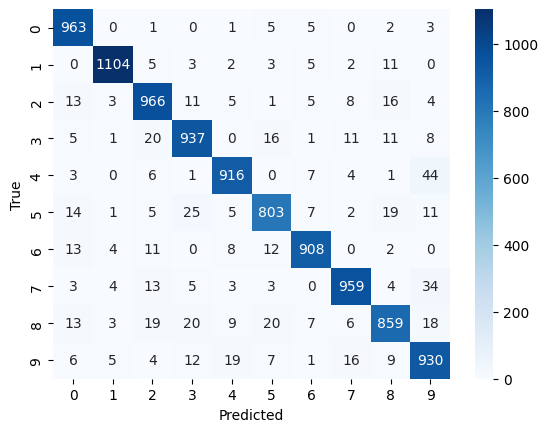

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.98      0.97      0.98      1135
           2       0.92      0.94      0.93      1032
           3       0.92      0.93      0.93      1010
           4       0.95      0.93      0.94       982
           5       0.92      0.90      0.91       892
           6       0.96      0.95      0.95       958
           7       0.95      0.93      0.94      1028
           8       0.92      0.88      0.90       974
           9       0.88      0.92      0.90      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

true_labels_all = []
predicted_labels_all = []

for i in range(len(test_data)):
    y_pred = np.argmax(feedforward_neural_network_classification(x_test[i, :], all_w_classification[k_best_classification]))
    true_labels = np.argmax(Y_test[i, :])

    true_labels_all.append(true_labels)
    predicted_labels_all.append(y_pred)


true_labels_all = np.array(true_labels_all)
predicted_labels_all = np.array(predicted_labels_all)
cm = confusion_matrix(true_labels_all, predicted_labels_all)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], yticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(classification_report(true_labels_all, predicted_labels_all, target_names=['0','1','2','3','4','5','6','7','8','9']))

Looking at the above graph I can clarify that:

$precision=\frac{True Positive}{True Positive+False Positive}$-It represents the proportion of positive instances predicted correctly among all positive instances predicted. High precision indicates that the model has fewer false positives.

$recall=\frac{True Positive}{True Positive+False Negative}$-It represents the proportion of positive instances that were predicted correctly among all real positive instances. A high recall indicates that the model has fewer false negatives

$F1score=2\cdot \frac{precision\cdot recall}{precision+recall}$-harmonic mean between precision and recall.It provides a balance between precision and recall. The F1-score is especially useful if we want to account for both false positives and false negatives. Closer it is to one the better is the balance between precision and recall

Looking at the values of the described ratios, we may conclude that our model works quite well and we also record a great trade off between false positives (that are in the column corresponding to the predicted class, but outside the diagonal) and false negatives (that are in the row corresponding to the actual class, but outside the diagonal).

As far as the accuracy of our model is concerned, which is tha ratio between the sum of the correct predictions and the total number of samples in our test data, we may conclude, since the ratio is high (equal to 93%), our model works well and correctly predict most of the features in our test data.

In [ ]:
accuracy = np.diag(cm).sum() / cm.sum()
print(f'Accuracy: {accuracy}')

Accuracy: 0.9345


In the final part of this work, the goal is to use the Python function ***visualize_digits_and_labels_and_predictions*** implemented above, to visualize the first 50 misclassified images by our model. As before, we se the image and above it the ***true label vs the predicted label***.

In [ ]:
misclassification = []
misclassified_indices = []
for i, (x, y_true) in enumerate(zip(x_test, y_test)):
    y_pred = (feedforward_neural_network_classification(x, all_w_classification[k_best_classification]))
    if np.argmax(y_pred) != y_true:
        misclassification.append(y_pred)
        misclassified_indices.append(i)
    if len(misclassified_indices) > 49:
        break

In [ ]:
visualize_digits_and_labels_and_predictions(x_test[misclassified_indices],
                                            Y_test[misclassified_indices],
                                            feedforward_neural_network_classification(x_test[misclassified_indices],
                                              all_w_classification[k_best_classification]))